# Dataset Source

This data we are investigation on the housing price information from the 1990 California census. The source of the dataset in found in Statlib Repository.

# Major Goal 

Build a model to be able to predict median housing price for any given district in California.

## Obtain the Data




In [50]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
fetch_housing_data()

# Import Libraries

In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns


## Load Data to Data Frame

In [52]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Exploring the Dataset

In [53]:
housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [54]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB



All of the variable colume names are self-explanatory, so I would not explain every value again.

Note that `total_bedrooms` has 207 null entries, and `ocean_proximity` is of object type. 

    -Null values will be dealt later because it needs to investigation into the datasets to find the correct strategy to resolve the null values issue.

    -ocean_proximity is of object value may be an signal of categorical datatypes.

Let's take a closer look.

In [55]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

As we guessed, the variable is indeed only with certain types for the colume value. 

In [56]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Noticeably, the unit of `median_income` may not be a per US dollar. It is actually expressed as tens of thousands of dollars which 1 stands for US $10,000.

There doesn't seem to be any other strange values. We'll visualize the numerical attributes' distribution for further investigation.

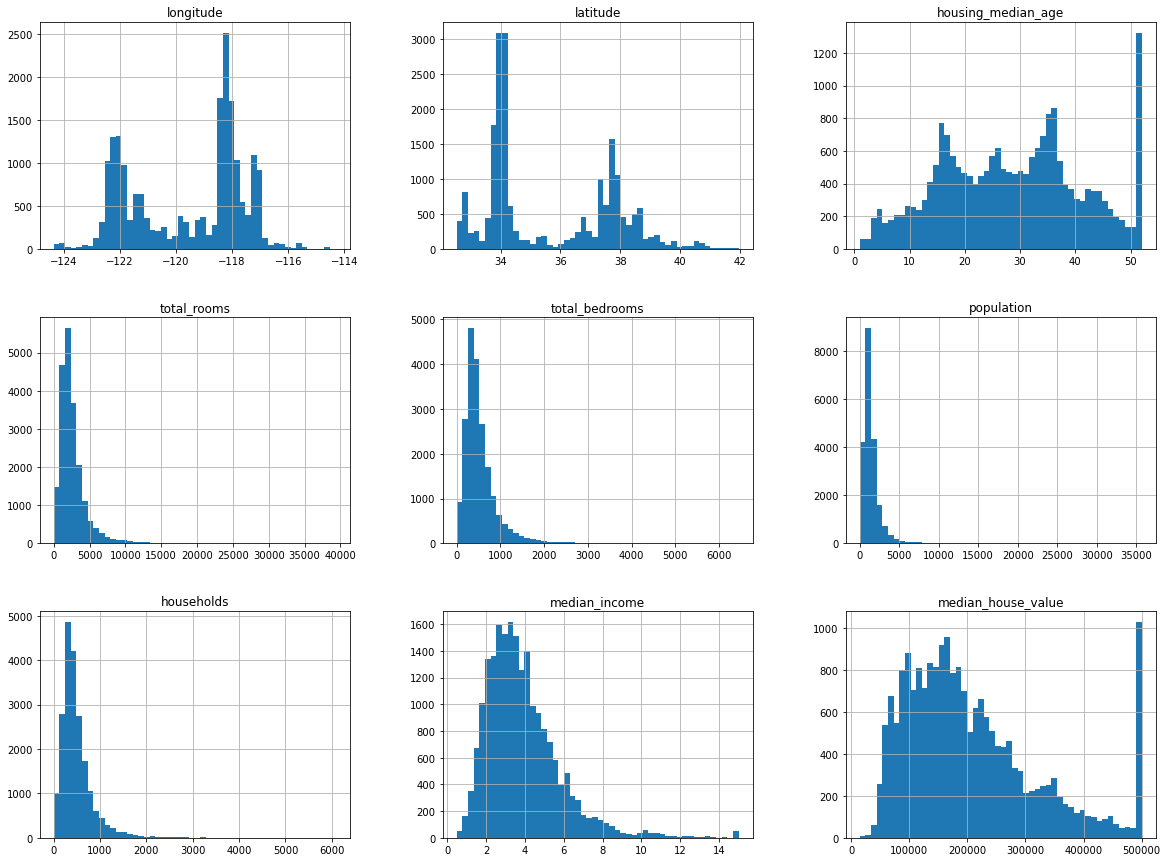

In [57]:
%matplotlib inline 
# setting graphical backend
from matplotlib import pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

Few things to note:
1. There is a particularly value in both `housing_median_age` and `median_house_value` that has a great number of occuring frequencies.
        -These columes are due to the techniques used during data collection. 
            -For **housing_median_age**, any house' age greater than 50 are classifiy as the same type under age 50.
            -The same rule applies to **median_house_value**
            -Although it is not obvious, **median_income** is also upper bounded at 15.0001 for high median income and lower bounded at 0.4999 for lower median income
        -To deal with these values:
            -Find people who collect these values to get exact data instead of the capped data if it is a real-life example.
            -We may remove those points at the upper bound; such that we avoid bad prediction with our model for value beyond the upper bound.
            
2. Most of the attributes here on the graph are *tail-heavy*; they extend much farther to the right of the median than to the left. We could **transform** these data to be bell-shaped later.

3. The scales differs much for each attribute, which we would need feature scaling.

## Create a Test Set

For the following analysis, we have made the assumption that `median_income` is the most important factor that influences the `median_house_value`. Therefore, when creating test set, we do not want to randomly split the data set since it would produce much sampling bias.

To make the test set be representative of the entire population. We will use **stratified sampling** to reduce sampling bias; and we group the median income in to categories of (0 - 1.5), (1.5 - 3.0), (3.0 - 4.5), (4.5 - 6), (6 - max)

<AxesSubplot:>

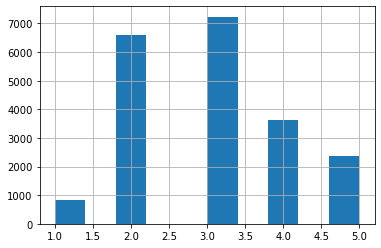

In [58]:
housing['income_category'] = pd.cut(housing['median_income'], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5]) 
# group the median_income into the designed categories
housing["income_category"].hist()


In [59]:
# We now separate the train, test set based on the median_income categories
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_category']):
    train_set = housing.iloc[train_index]
    test_set = housing.iloc[test_index]
    
train_set.shape, test_set.shape


((16512, 11), (4128, 11))

In [ ]:
# We now drop the income category colume to bring the data frame to its original state

for sets in (train_set, test_set):
    sets.drop("income_category", axis = 1, inplace = True)

In [65]:
# check to make sure the colume is correctly removed
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [67]:
# create a copy of the train set, so that we do not manipulate the train set by mistake
housing = train_set.copy()

### Visualizing the Geographical Data

The longitude and latitude of data may shows that particular regions have a high influence on the overall price which is a common situation. Let's visualize the data to see if this situation actually exist, and where are these places.

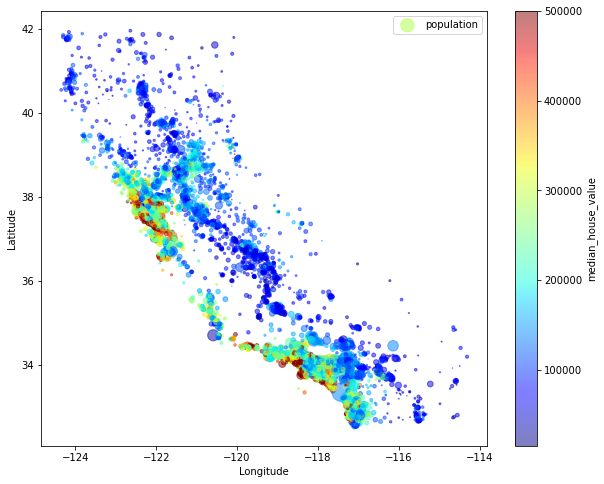

In [90]:
fig,ax = plt.subplots(figsize = (10, 8))
plt.scatter(housing.longitude, housing.latitude, alpha = 0.5,
            s = housing['population']/100, c=housing.median_house_value, cmap=plt.get_cmap('jet'))
cbar = plt.colorbar()
cbar.set_label("median_house_value")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(labels = ['population', 'median_house_value'])

In this graph, the size of the circle is a representation of the density of population at that area. The colorbar is a representation of how is median house value is at that area, which the darker the color the higher the median value.

By observation, we can find that the median house value has an association with the house location and the density of population. From the graph, it roughly show that the area that more people live in would has a relatively higher median house value; and the closeness of the houses with ocean may positvely related to the median house value. Therefore, the proximity to ocean is useful for the analysis with respect to the geographical attribute as well.

*From the above interpretation, a clustering algorithm may be useful for detecting main cluster and for adding new features that measure the proximity to the cluster centers.*

## Variable Correlations

<AxesSubplot:>

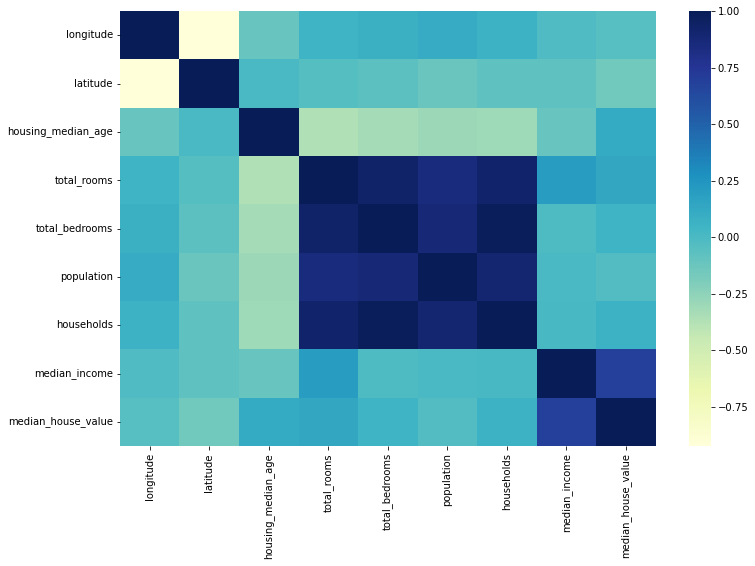

In [99]:
# obtain the correlation matrix
fig = plt.figure(figsize = (12, 8))
corr_matrix = housing.corr()
sns.heatmap(corr_matrix, cmap="YlGnBu")

By observing the value across the line of median_house_value, we could find that it is most correlated with median income.

Let's plot their scatter plot to further investigate their relationship.

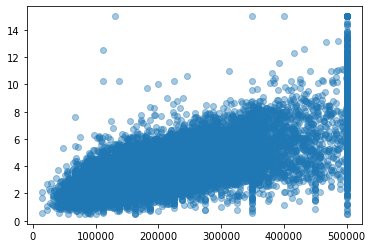

In [100]:
plt.scatter(housing.median_house_value, housing.median_income, alpha = 0.4)

Clearly, the two features are strongly, positvely related; which the graph shows a general upward trend with not many points dispersed around. 

The bar at the rightmost area is from the special data collection procedure mentioned above; so we'll ignore it for the overall pattern analysis. Besides this rightmost, vertial bar, it seems the points on median house value of \\$350,000 and \\$450,000 also forms a vertial line.

*We may need to remove these values, so that our model do not produce the same data quirks*


### Attribute Combinations